In [1]:
from pathlib import Path

import polars as pl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_pth = Path('../../data/')

In [3]:
time_intervals = pl.read_csv(data_pth/ 'grade_timesteps.csv')

In [4]:
# time_intervals = pl.read_csv(data_pth/ 'time_intervals.csv')

In [5]:
time_intervals_final = time_intervals.group_by('id').agg(pl.col('dt').diff().quantile(0.9))


In [6]:
df = pl.read_csv(data_pth/'graded_data.csv')
area_delta = df[['id','area']].group_by('id').agg(pl.col('area').max()-pl.col('area').min())

large_blasto_mask = area_delta['area']>8000

selected_ids = area_delta.filter(large_blasto_mask.to_list())['id']

final_df = df.filter(df["id"].is_in(selected_ids))
    

In [7]:
df['area'].max()

30496

In [8]:
time_intervals['dt'].diff().hist

<bound method Series.hist of shape: (1_195_359,)
Series: 'dt' [f64]
[
	null
	0.010745
	0.010423
	0.010429
	0.010417
	…
	0.006874
	0.006959
	0.006944
	0.006945
	0.007021
]>

In [9]:
time_intervals.group_by('id').agg(pl.col('dt').diff().mean())

id,dt
str,f64
"""D2017.11.04_S01647_I0149_D_5""",0.01045
"""D2018.12.05_S01916_I0149_D_4""",0.010546
"""D2019.02.18_S01956_I0149_D_9""",0.010518
"""D2016.04.05_S1274_I149_12""",0.006967
"""D2018.03.16_S01744_I0149_D_7""",0.010581
…,…
"""D2017.11.22_S01667_I0149_D_8""",0.01048
"""D2016.07.07_S1364_I149_1""",0.007021
"""D2019.02.23_S01962_I0149_D_3""",0.010431


In [10]:
from scipy.ndimage import gaussian_filter1d
# Example data\
def get_inflection_points(area):
    x = np.array(range(area.shape[0]))
    y =  gaussian_filter1d(area, sigma=10)

    # Fit a polynomial of degree 3
    degree = 5
    coeffs = np.polyfit(x, y, degree)
    polynomial = np.poly1d(coeffs)

    # Compute the first and second derivatives
    first_derivative = polynomial.deriv()
   

    # Find roots of the second derivative
    local_extrema = np.roots(first_derivative)

    # Filter roots within the data range
    local_extrema = local_extrema[(local_extrema >= x.min()) & (local_extrema <= x.max())]

    # Find the idx that 
    # Mark deflection points
    return list(set([int(dp.real) for dp in local_extrema]))


In [11]:
# from scipy.signal import find_peaks
# def get_inflection_points(area):
    
#     x = np.arange(len(area.to_numpy()))
#     y = area  # Your data here


#     # Compute the first and second derivatives
#     dy = np.gradient(y)
#     d2y = np.gradient(dy)

#     # Set a threshold for the second derivative
#     threshold = np.max(d2y) * 0.3

#     sharp_points, _ = find_peaks(d2y, height=threshold)
    
#     return sharp_points

In [12]:
import polars as pl
from multiprocessing import Pool, cpu_count

# Example function
# def get_inflection_points(area_series):
#     # Perform computations here
#     return some_result

# Parallel processing wrapper
def process_group(group):
    group_id, group_data, embryo_dt = group
    
    if embryo_dt.is_empty():
        return group_id, 0

    if "dt" not in embryo_dt.columns:
        raise ValueError(f"Column 'dt' not found in time_intervals_final for id {group_id[0]}")

    # Compute peaks
    peaks = get_inflection_points(group_data["area"])

    # Ensure dt_in_hours is a scalar or iterable
    dt_in_hours = embryo_dt["dt"].item()*1440/60  # Convert to list


    # if len(dt_in_hours) != 1:
    #     raise ValueError(f"Expected one dt value per group but found {len(dt_in_hours)} for id {group_id[0]}")

    # Extract the scalar value for dt
    dt_in_hours_scalar = dt_in_hours

    area_peaks = group_data["area"].to_numpy()[peaks]
    

    max_diff = (group_data["area"].max()-area_peaks)>1000

    # print(type(peaks))
    # Filter peaks
    ok_peaks = np.array(peaks)[np.array(max_diff)]
    if any(ok_peaks):
        return group_id, np.max(ok_peaks)
    # Return the minimum valid peak
    return group_id, max(peaks)
# Extract groups, process in parallel, and reconstruct
def parallel_map_groups(df, group_column, time_intervals_final):
    grouped = df.group_by(group_column, maintain_order=True)
    groups = [
        (group_id, group_data, time_intervals_final.filter(pl.col("id") == group_id[0]))
        for group_id, group_data in grouped
    ]
    
    # Set process count based on available cores
    num_processes = min(len(groups), cpu_count())

    with Pool(processes=num_processes) as pool:
        results = pool.map(process_group, groups)
    
    # Filter out groups with no valid peaks
    results = [(group_id, corr) for group_id, corr in results if corr is not None]
    
    # Rebuild the dataframe
    return pl.DataFrame({"id": [result[0][0] for result in results], "peak": [result[1] for result in results]})

# Apply to your data
peaks_area = parallel_map_groups(final_df, "id", time_intervals_final)



In [13]:
peaks_area

id,peak
str,i64
"""D2016.01.05_S1181_I149_6""",416
"""D2016.01.05_S1181_I149_9""",520
"""D2016.01.11_S1183_I149_4""",516
"""D2016.01.21_S1198_I149_10""",505
"""D2016.01.21_S1198_I149_7""",531
…,…
"""D2019.05.12_S01995_I0149_D_1""",331
"""D2019.05.12_S01995_I0149_D_4""",308
"""D2019.05.18_S01997_I0149_D_6""",342


In [14]:
peaks_area.filter(pl.col('id')=='D2018.11.02_S01893_I0149_D_5')

id,peak
str,i64
"""D2018.11.02_S01893_I0149_D_5""",291


In [15]:
final_df.filter(pl.col('id')=='D2016.03.13_S1258_I149_11')['area'].shape

(698,)

In [16]:
peaks_area.write_csv(data_pth/'area_peaks.csv')

In [17]:
area = final_df.filter(pl.col('id')=='D2018.11.02_S01893_I0149_D_5')['area'].to_numpy()

In [18]:
dt = time_intervals_final.filter(pl.col("id") == 'D2018.11.02_S01893_I0149_D_5')

In [19]:
dt['dt']*1440/60

dt
f64
0.252411


In [20]:
dy = np.gradient(area)

In [21]:
d2y = np.gradient(dy)

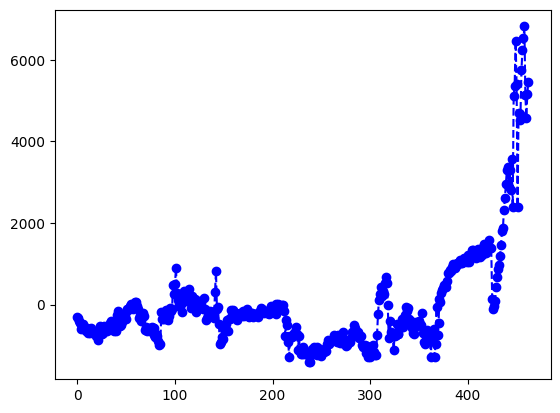

In [22]:
plt.plot(area-np.mean(area),'--bo',)

/home/tsakalis/ntua/phd/cellforge/cellforge_venv/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


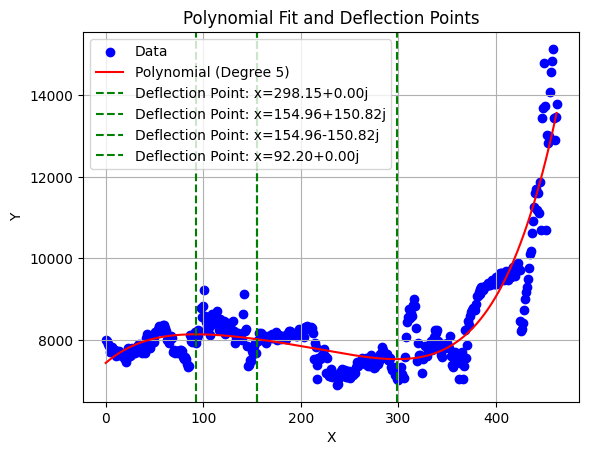

Deflection points: [298.15209959  +0.j         154.96058273+150.81647334j
 154.96058273-150.81647334j  92.1953346   +0.j        ]


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d


# Example data
x = np.array(range(area.shape[0]))
y =  area#gaussian_filter1d(area, sigma=40)

# Fit a polynomial of degree 3
degree = 5
coeffs = np.polyfit(x, y, degree)
polynomial = np.poly1d(coeffs)

# Compute the first and second derivatives
first_derivative = polynomial.deriv()
second_derivative = first_derivative.deriv()

# Find roots of the second derivative
deflection_points = np.roots(first_derivative)

# Filter roots within the data range
deflection_points = deflection_points[(deflection_points >= x.min()) & (deflection_points <= x.max())]

# Plot the data and polynomial
plt.scatter(x, y, label="Data", color="blue")
x_fit = np.linspace(x.min(), x.max(), 500)
y_fit = polynomial(x_fit)
plt.plot(x_fit, y_fit, label=f"Polynomial (Degree {degree})", color="red")

# Mark deflection points
for dp in deflection_points:
    plt.axvline(dp, color="green", linestyle="--", label=f"Deflection Point: x={dp:.2f}")

plt.legend()
plt.title("Polynomial Fit and Deflection Points")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid()
plt.show()

# Print deflection points
print("Deflection points:", deflection_points)


In [24]:
for dp in deflection_points:
    print(int(dp.real))

298
154
154
92
